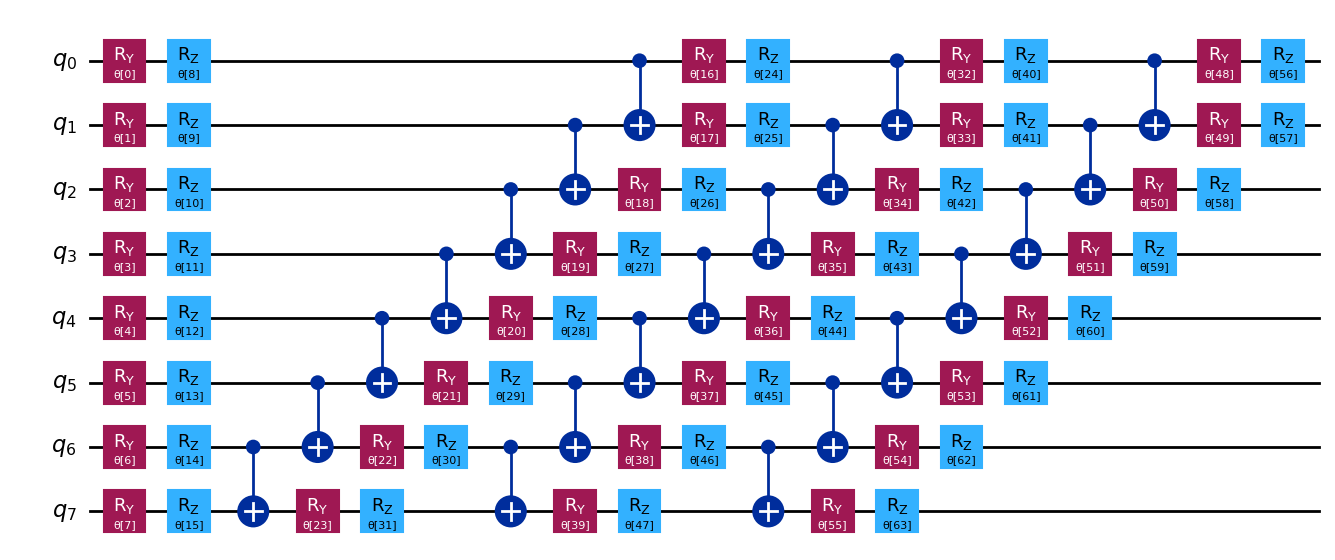

In [19]:
from qiskit.circuit.library import EfficientSU2
 
n_qubits = 8
circuit = EfficientSU2(n_qubits)
circuit.decompose().draw("mpl")

In [20]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
 
observable = SparsePauliOp("Z" * n_qubits)
params = [0.1] * circuit.num_parameters
 
exact_estimator = Estimator()
# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(3, AerSimulator())
isa_circuit = pass_manager.run(circuit)
pub = (isa_circuit, observable, params)
job = exact_estimator.run([pub])
result = job.result()
pub_result = result[0]
exact_value = float(pub_result.data.evs)
exact_value

0.8870140234256602

In [22]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
 
noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)
 
noisy_estimator = Estimator(options=dict(backend_options=dict(noise_model=noise_model)))
job = noisy_estimator.run([pub])
result = job.result()
pub_result = result[0]
noisy_value = float(pub_result.data.evs)
noisy_value

AttributeError: 'NoiseModel' object has no attribute 'run'

In [31]:
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
# Bell Circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
 
service = QiskitRuntimeService()
 
# Specify a QPU to use for the noise model
real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(backend=aer)
result = sampler.run([isa_qc]).result()

/var/folders/ys/tg4mzr093dsgjjl04f5n863c0000gn/T/ipykernel_18510/956006391.py:21: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=aer)


AttributeError: 'NoiseModel' object has no attribute 'run'

In [27]:
import qiskit_aer.noise as noise

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['rz', 'sx', 'cx', 'x']
  All-qubits errors: ['rz', 'sx', 'x', 'cx']


In [34]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
n_qubits = 5  # <---- note this uses 500 qubits!
circuit = EfficientSU2(n_qubits)
circuit.measure_all()
 
rng = np.random.default_rng(1234)
params = rng.choice(
    [0, np.pi / 2, np.pi, 3 * np.pi / 2],
    size=circuit.num_parameters,
)
 
# Tell Aer to use the stabilizer (clifford) simulation method
aer_sim = AerSimulator(method="stabilizer")
 
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(mode=aer_sim)
result = sampler.run([isa_qc]).result()
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>)))], metadata={})


In [41]:
rng = np.random.default_rng(1234)
rng.random()

0.3801957350196178

In [42]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
 
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [43]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

In [44]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [45]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


In [46]:
# Tensor product two bit-flip and phase-flip errors with
# bit-flip on qubit-0, phase-flip on qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


In [47]:
# Convert to Kraus operator
bit_flip_kraus = Kraus(bit_flip)
print(bit_flip_kraus)

Kraus([[[ 9.74679434e-01+0.j,  0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j,  9.74679434e-01+0.j]],

       [[ 0.00000000e+00+0.j,  2.23606798e-01+0.j],
        [ 2.23606798e-01+0.j, -4.96506831e-17+0.j]]],
      input_dims=(2,), output_dims=(2,))


In [48]:
# Convert to Superoperator
phase_flip_sop = SuperOp(phase_flip)
print(phase_flip_sop)

SuperOp([[1. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0.9+0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0.9+0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 1. +0.j]],
        input_dims=(2,), output_dims=(2,))


In [49]:
# Convert back to a quantum error
print(QuantumError(bit_flip_kraus))
 
# Check conversion is equivalent to original error
QuantumError(bit_flip_kraus) == bit_flip

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───────┐
q: ┤ kraus ├
   └───────┘


True

In [50]:
# Create an empty noise model
noise_model = NoiseModel()
from qiskit_aer.primitives import Estimator
sampler_n = Estimator()
sampler_n.set_options()
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
 
# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']
